In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# Load dataset
file_path = 'DATA.xlsx'  # Replace with your dataset path
data = pd.read_excel(file_path)

# Preprocess 'YEARS' to extract the starting year
data['Year'] = data['YEARS'].str.split('-').str[0].astype(int)
data = data[['Year', 'Consumption']].sort_values(by='Year').reset_index(drop=True)

# Display the dataset
data.head()


,Year,Consumption
0,1979,542254.0
1,1980,589017.0
2,1981,644907.0
3,1982,690214.0
4,1983,754725.0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

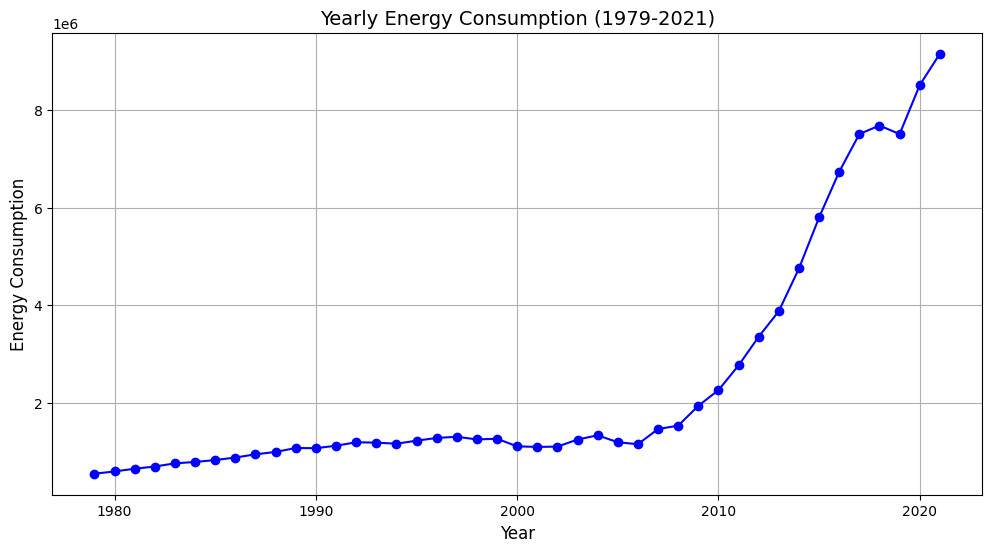

In [6]:
# Plot initial data
plt.figure(figsize=(12, 6))
plt.plot(data['Year'], data['Consumption'], marker='o', color='b')
plt.title('Yearly Energy Consumption (1979-2021)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Energy Consumption', fontsize=12)
plt.grid(True)
plt.show()


In [7]:
# Feature Engineering: Adding lagged features and a quadratic term
data['Lag_1'] = data['Consumption'].shift(1)  # Lag 1 year
data['Lag_2'] = data['Consumption'].shift(2)  # Lag 2 years
data['Year_Squared'] = data['Year'] ** 2      # Quadratic term for trend

# Drop rows with NaN values caused by lagging
data = data.dropna().reset_index(drop=True)

# Display the updated dataset
data.head()


,Year,Consumption,Lag_1,Lag_2,Year_Squared
0,1981,644907.0,589017.0,542254.0,3924361
1,1982,690214.0,644907.0,589017.0,3928324
2,1983,754725.0,690214.0,644907.0,3932289
3,1984,783807.0,754725.0,690214.0,3936256
4,1985,822735.0,783807.0,754725.0,3940225


In [8]:
# Train-test split
train_data = data[data['Year'] <= 2015]  # Train on data up to 2015
test_data = data[data['Year'] > 2015]    # Test on data after 2015

X_train = train_data[['Year', 'Year_Squared', 'Lag_1', 'Lag_2']]
y_train = train_data['Consumption']
X_test = test_data[['Year', 'Year_Squared', 'Lag_1', 'Lag_2']]
y_test = test_data['Consumption']

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (35, 4)
Testing set size: (6, 4)


In [21]:
# Feature engineering for time-based features
X_train['Year'] = train_data['Year']
X_train['Year_squared'] = train_data['Year'] ** 2

X_test['Year'] = test_data['Year']
X_test['Year_squared'] = test_data['Year'] ** 2


C:\Users\MoaviaHassan\AppData\Local\Temp\ipykernel_1544\2130880836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Year'] = train_data['Year']
C:\Users\MoaviaHassan\AppData\Local\Temp\ipykernel_1544\2130880836.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Year'] = test_data['Year']


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))


In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Step 1: Initialize XGBRegressor and perform Grid Search
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 300, 500],
    'max_depth': [2, 4, 6, 8],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}


xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 3 folds for each of 384 candidates, totalling 1152 fits
Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}


c:\Users\MoaviaHassan\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[0]	validation_0-rmse:6201919.12789
[1]	validation_0-rmse:6092971.43871
[2]	validation_0-rmse:5988412.17662
[3]	validation_0-rmse:5888064.70457
[4]	validation_0-rmse:5784236.65069
[5]	validation_0-rmse:5684334.49721
[6]	validation_0-rmse:5594981.54204
[7]	validation_0-rmse:5502237.32643
[8]	validation_0-rmse:5413000.95778
[9]	validation_0-rmse:5327140.29392
[10]	validation_0-rmse:5244528.24092
[11]	validation_0-rmse:5165041.70445
[12]	validation_0-rmse:5093944.20527
[13]	validation_0-rmse:5012993.61236
[14]	validation_0-rmse:4934772.62143
[15]	validation_0-rmse:4859189.06049
[16]	validation_0-rmse:4786154.52969
[17]	validation_0-rmse:4715583.37417
[18]	validation_0-rmse:4647392.57218
[19]	validation_0-rmse:4581502.66313
[20]	validation_0-rmse:4517835.89453
[21]	validation_0-rmse:4456317.50789
[22]	validation_0-rmse:4396875.25416
[23]	validation_0-rmse:4344316.93263
[24]	validation_0-rmse:4288654.76999
[25]	validation_0-rmse:4234871.68783
[26]	validation_0-rmse:4182903.94491
[27]	valida

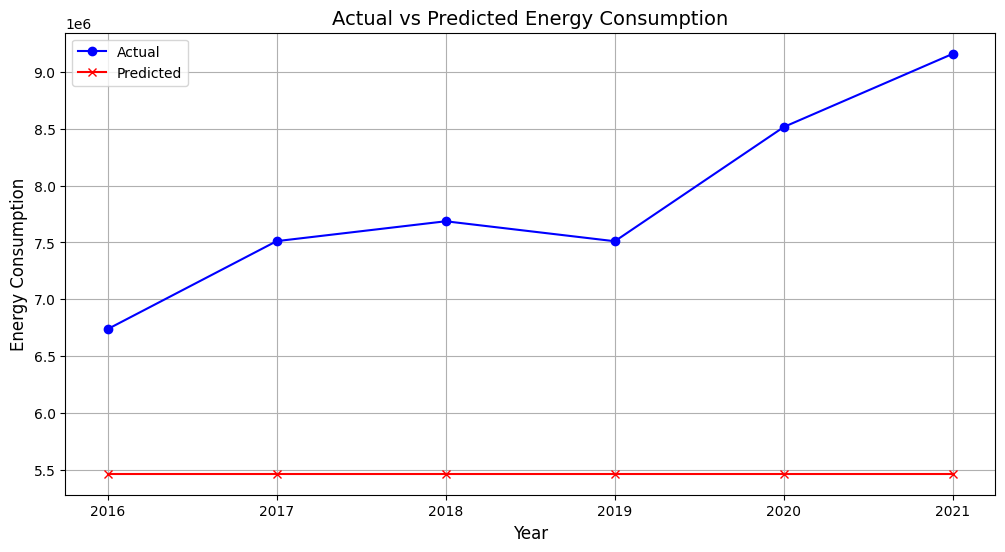

In [23]:
# Initialize the final model with best parameters
best_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=10, 
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth']
)

# Train the model with early stopping
best_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],  # Validation set for early stopping
       # Stop if no improvement in 10 rounds
    verbose=True                 # Show training progress
)

# Predictions on the test set
y_pred = best_model.predict(X_test)

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_data['Year'], y_test, marker='o', label='Actual', color='blue')
plt.plot(test_data['Year'], y_pred, marker='x', label='Predicted', color='red')
plt.title('Actual vs Predicted Energy Consumption', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Energy Consumption', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [24]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
maep = mae / np.mean(y_test) * 100

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAEP: {maep:.2f}%")


MAE: 2386631.81
R²: -9.3625
MAEP: 30.39%
